## Sample size calculations for various approaches
Calculating the sample sizes for various approaches to answering the following questions
1. For evals where a code review or testing reveals a problem, how many transcripts must be evaluated to determine whether a benchmark has at least one violation demonstrated (Section 1)?
2. What percentage of transcripts demonstrate this violation? (Section 2)
    - **This notebook** does this analysis, finding the n needed to achieve different levels of precision under different assumptions.
3. For transcripts which demonstrate violations (as determined by gold standard human graders), how often is this violation detected by automated transcript analysis via scanners? (Section 3)


In [2]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

### 2. Estimating sample sizes needed for various precision levels
For the question of 'what is the base rate' we are not really doing a hypothesis test, so a true power analysis wouldn't make sense. Instead we want to look at what degree of precision we could obtain under various assumptions (i.e., if we have transcripts with a true violation rate p, what number of transcripts n need to be graded to get an estimate within a specified tolerance).

This is a straightforward: p = p_h +- z/sqrt(n) * sqrt(p_h*(1-p_h))

There are two ways to approach this: the naive assumption that human graders are perfect (sens and spec == 1), and a better assumption that there is some possibility for graders to fail by either false negative or false positive. This second assumption is also nice because it directly translates to the scanner case, and can be reused when writing the paper about scanner effectiveness.

I'll still start with the naive approach, as that lets me sanity check the more complicated version

In [3]:
# Naive approach: graders are assumed to be perfect so any given graded transcript can identify violations

def n_required_perfect_graders(p, m=0.01, alpha=0.05, N=None, deff=1.0):
    """
    Required n so that approx (1-alpha) CI half-width for the naive estimator p-hat = Y_bar
    is <= m, under the assumption graders are perfect (Se=Sp=1), i.e., Y_i == E_i.

    Parameters
    ----------
    p : float
        True error rate (prevalence), 0 < p < 1.
    m : float
        Target absolute margin of error (CI half-width).
    alpha : float
        Two-sided alpha level (0.05 -> 95% CI).
    N : int or None
        Finite population size (sampling without replacement). If provided, applies FPC.
    deff : float
        Design effect multiplier (e.g., clustering by grader); deff=1 for i.i.d.

    Returns
    -------
    int
        Ceiling of required sample size.
    """
    if not (0 < p < 1):
        raise ValueError("p must be in (0,1).")

    z = norm.ppf(1 - alpha / 2)

    # Perfect graders => observed rate q == p and estimator is p-hat = Y_bar
    n0 = (z**2 * p * (1 - p)) / (m**2)

    # Finite population correction (closed form)
    if N is not None:
        if N <= 1:
            raise ValueError("N must be > 1.")
        n0 = (N * n0) / (N + n0 - 1)

    return int(np.ceil(n0 * deff))


def grid_table_perfect_graders(ps, m=0.01, alpha=0.05, N=None, deff=1.0):
    """
    Convenience helper to compute required n over a list/array of p values.
    Returns a list of tuples: (p, n_required).
    """
    out = []
    for p in ps:
        out.append((float(p), n_required_perfect_graders(p, m=m, alpha=alpha, N=N, deff=deff)))
    return out


print(n_required_perfect_graders(p=0.10, m=0.05, alpha=0.05))

# Grid example:
ps = [0.01, 0.02, 0.05, 0.10]
print(grid_table_perfect_graders(ps, m=0.01, alpha=0.05))

#checking that my math is right with a manual calc: equation for conf int with p = 0.10, z=1.96, n=139 (should be +- 5%, so 5<p<15% )
# p=0.01
# alpha=0.05
# z = norm.ppf(1 - alpha / 2)
# n=139
# p_upper = p+(z/n**0.5)*(p*(1-p))**0.5
# p_lower = p-(z/n**0.5)*(p*(1-p))**0.5
# print(p_upper,p_lower)



139
[(0.01, 381), (0.02, 753), (0.05, 1825), (0.1, 3458)]


In [4]:


def n_required(p, se, sp=1.0, m=0.01, alpha=0.05, N=None, deff=1.0):
    """
    Required n so that approx (1-alpha) CI half-width for corrected p-hat is <= m.
    Assumes Se, Sp known (no uncertainty in calibration).
    Optionally applies finite population correction for sampling without replacement from N.
    Optionally inflates by design effect deff (e.g., grader clustering).
    """
    z = norm.ppf(1 - alpha/2)
    denom = (se + sp - 1.0)
    if denom <= 0:
        raise ValueError("Se + Sp must exceed 1 (otherwise correction is not identifiable).")

    q = p*se + (1-p)*(1-sp)  # observed positive rate
    n0 = (z**2 * q * (1 - q)) / (m**2 * denom**2)

    # finite population correction (closed form)
    if N is not None:
        n0 = (N * n0) / (N + n0 - 1)

    return float(np.ceil(n0 * deff))

# def grid_table(ps, ses, sps, ms, alpha=0.05, N=None, deff=1.0):
#     out = []
#     for p in ps:
#         for se in ses:
#             for sp in sps:
#                 for m in ms:
#                     out.append((p, se, sp, n_required(p, se, sp, m, alpha=alpha, N=N, deff=deff)))
#     return out
# actually prefer this as a df for clarity and plotting
def grid_table(ps, ses, sps, ms, alpha=0.05, N=None, deff=1.0):
    """
    Generate a DataFrame of required sample sizes across parameter combinations.
    """
    rows = []
    for p in ps:
        for se in ses:
            for sp in sps:
                for m in ms:
                    n = n_required(p, se, sp, m, alpha=alpha, N=N, deff=deff)
                    rows.append({'p': p, 'sensitivity': se, 'specificity': sp, 'm': m, 'n_required': n})
    return pd.DataFrame(rows)

# Example:
print(n_required(p=0.10, se=0.90, sp=.99, m=0.05, alpha=0.05))

174.0


In [6]:
# Now that I have some functions to generate grids, I want to run those grids over plausible ranges of error rate p.
# I want to have some plots that hold Se and Sp constant, plot various choices for true error rate in color, various choices for m on the y axis, and n on the x axis.
# 
# 
ps = [0.2,0.1,0.05,0.01]
ms = [0.10,0.05,0.01]
ses = [0.95]
sps = [0.99]

print(grid_table(ps,ses,sps,ms))

ses = [0.5]
sps = [0.99]

print(grid_table(ps,ses,sps,ms))




       p  sensitivity  specificity     m  n_required
0   0.20         0.95         0.99  0.10        70.0
1   0.20         0.95         0.99  0.05       277.0
2   0.20         0.95         0.99  0.01      6904.0
3   0.10         0.95         0.99  0.10        41.0
4   0.10         0.95         0.99  0.05       163.0
5   0.10         0.95         0.99  0.01      4052.0
6   0.05         0.95         0.99  0.10        24.0
7   0.05         0.95         0.99  0.05        94.0
8   0.05         0.95         0.99  0.01      2337.0
9   0.01         0.95         0.99  0.10         9.0
10  0.01         0.95         0.99  0.05        34.0
11  0.01         0.95         0.99  0.01       828.0
       p  sensitivity  specificity     m  n_required
0   0.20          0.5         0.99  0.10       155.0
1   0.20          0.5         0.99  0.05       617.0
2   0.20          0.5         0.99  0.01     15414.0
3   0.10          0.5         0.99  0.10        89.0
4   0.10          0.5         0.99  0.05      

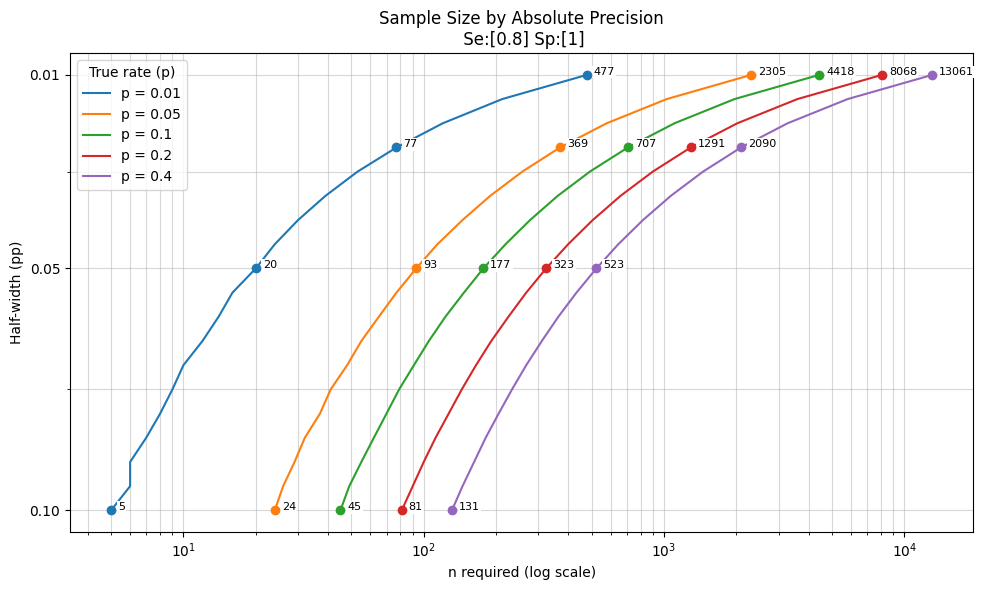

In [35]:
# Fine-grained data for smooth lines
ms_fine = np.arange(0.01, 0.105, 0.005)
ps = [0.01, 0.05, 0.10, 0.20, 0.4]
ses = [0.80]
sps = [1]

df_fine = grid_table(ps,ses,sps,ms_fine)

# Sparse data for points and labels
ms_points = [0.01, 0.025, 0.05, 0.10]
df_points = grid_table(ps,ses,sps,ms_points)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10.colors

for i, (p, group) in enumerate(df_fine.groupby('p')):
    # Draw smooth lines
    ax.plot(group['n_required'], group['m'], color=colors[i], label=f'p = {p}')
    
    # Draw points at specific m values
    points = df_points[df_points['p'] == p]
    ax.scatter(points['n_required'], points['m'], color=colors[i], zorder=5)
    
    # Add labels at points
    for _, row in points.iterrows():
        ax.annotate(f'{int(row["n_required"])}', 
                    (row['n_required'], row['m']),
                    textcoords='offset points',
                    xytext=(5, 0),
                    fontsize=8,
                    bbox=dict(facecolor='white', edgecolor='none', pad=1))
        

ax.set_xscale('log')
ax.invert_yaxis()
ax.set_yticks([0.01, 0.05, 0.1])
ax.set_yticks([.03, 0.075], minor = True)
ax.set_xlabel('n required (log scale)')
ax.set_ylabel('Half-width (pp)')
ax.legend(title='True rate (p)')
ax.set_title(f'Sample Size by Absolute Precision\n Se:{ses} Sp:{sps}')
ax.grid(True,which='both', alpha = 0.5)
plt.tight_layout()
plt.show()

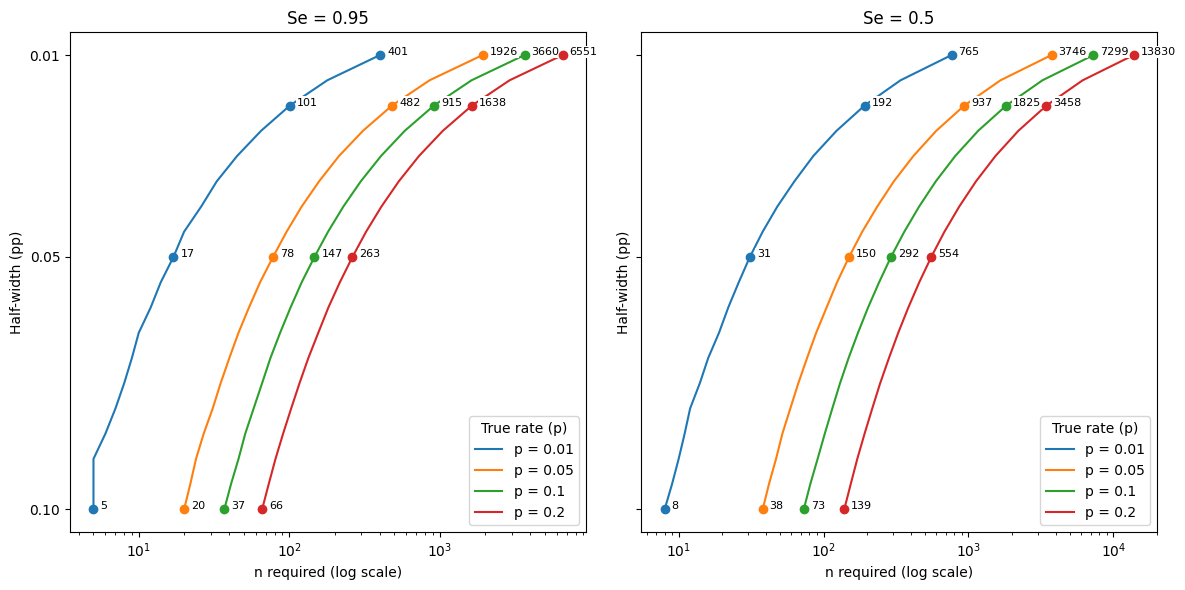

In [26]:
# Fine-grained data for smooth lines
ms_fine = np.arange(0.01, 0.105, 0.005)
ps = [0.01, 0.05, 0.10, 0.20]
ses = [0.95, 0.5]
sps = [1]

df_fine = grid_table(ps, ses, sps, ms_fine)

# Sparse data for points and labels
ms_points = [0.01, 0.02, 0.05, 0.10]
df_points = grid_table(ps, ses, sps, ms_points)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
colors = plt.cm.tab10.colors

for ax, se in zip(axes, ses):
    df_fine_se = df_fine[df_fine['sensitivity'] == se]
    df_points_se = df_points[df_points['sensitivity'] == se]
    
    for i, (p, group) in enumerate(df_fine_se.groupby('p')):
        # Draw smooth lines
        ax.plot(group['n_required'], group['m'], color=colors[i], label=f'p = {p}')
        
        # Draw points at specific m values
        points = df_points_se[df_points_se['p'] == p]
        ax.scatter(points['n_required'], points['m'], color=colors[i], zorder=5)
        
        # Add labels at points
        for _, row in points.iterrows():
            ax.annotate(f'{int(row["n_required"])}', 
                        (row['n_required'], row['m']),
                        textcoords='offset points',
                        xytext=(5, 0),
                        fontsize=8,
                        bbox=dict(facecolor='white', edgecolor='none', pad=1))

    ax.set_xscale('log')
    ax.set_yticks([0.01, 0.05, 0.1])
    ax.set_xlabel('n required (log scale)')
    ax.set_title(f'Se = {se}')
    ax.set_ylabel('Half-width (pp)')
    ax.legend(title='True rate (p)', loc='lower right')
ax.invert_yaxis()

#fig.suptitle(f'Sample Size Required by Margin and True Violation Rate (Sp: {sps[0]})', y=1.02)
plt.tight_layout()
plt.show()


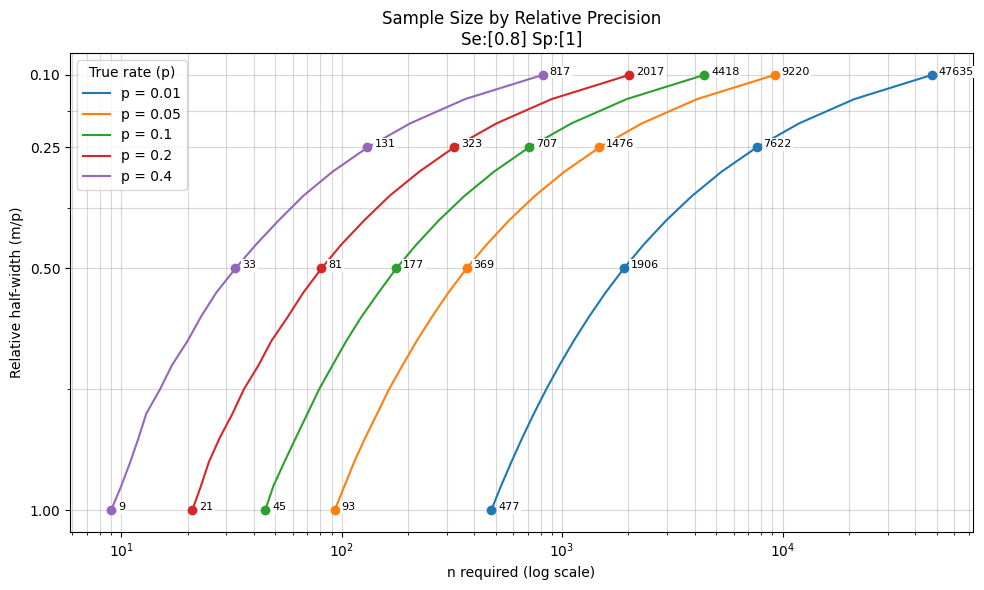

In [33]:
# Fine-grained data for smooth lines
m_fracs_fine = np.arange(0.1, 1.05, 0.05)  # m as fraction of p (10% to 100%)
ps = [0.01, 0.05, 0.10, 0.20, 0.4]
ses = [0.8]
sps = [1]

rows_fine = []
for p in ps:
    for m_frac in m_fracs_fine:
        m = m_frac * p
        for se in ses:
            for sp in sps:
                n = n_required(p, se, sp, m=m)
                rows_fine.append({'p': p, 'm_frac': m_frac, 'm': m, 'n_required': n})

df_fine = pd.DataFrame(rows_fine)

# Sparse data for points and labels
m_fracs_points = [0.1, 0.25, 0.5, 1.0]
rows_points = []
for p in ps:
    for m_frac in m_fracs_points:
        m = m_frac * p
        for se in ses:
            for sp in sps:
                n = n_required(p, se, sp, m=m)
                rows_points.append({'p': p, 'm_frac': m_frac, 'm': m, 'n_required': n})

df_points = pd.DataFrame(rows_points)

# Plot - using m_frac on y-axis for comparability across p values
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10.colors

for i, (p, group) in enumerate(df_fine.groupby('p')):
    ax.plot(group['n_required'], group['m_frac'], color=colors[i], label=f'p = {p}')
    
    points = df_points[df_points['p'] == p]
    ax.scatter(points['n_required'], points['m_frac'], color=colors[i], zorder=5)
    
    for _, row in points.iterrows():
        ax.annotate(f'{int(row["n_required"])}', 
                    (row['n_required'], row['m_frac']),
                    textcoords='offset points',
                    xytext=(5, 0),
                    fontsize=8,
                    bbox=dict(facecolor='white', edgecolor='none', pad=1))

ax.set_xscale('log')
ax.invert_yaxis()
ax.set_yticks([0.1, 0.25, 0.5, 1.0])
ax.set_yticks([0.175,.375, 0.75], minor = True)
ax.set_xlabel('n required (log scale)')
ax.set_ylabel('Relative half-width (m/p)')
ax.legend(title='True rate (p)')
ax.set_title(f'Sample Size by Relative Precision\nSe:{ses} Sp:{sps}')
ax.grid(True,which='both', alpha = 0.5)

plt.tight_layout()
plt.show()


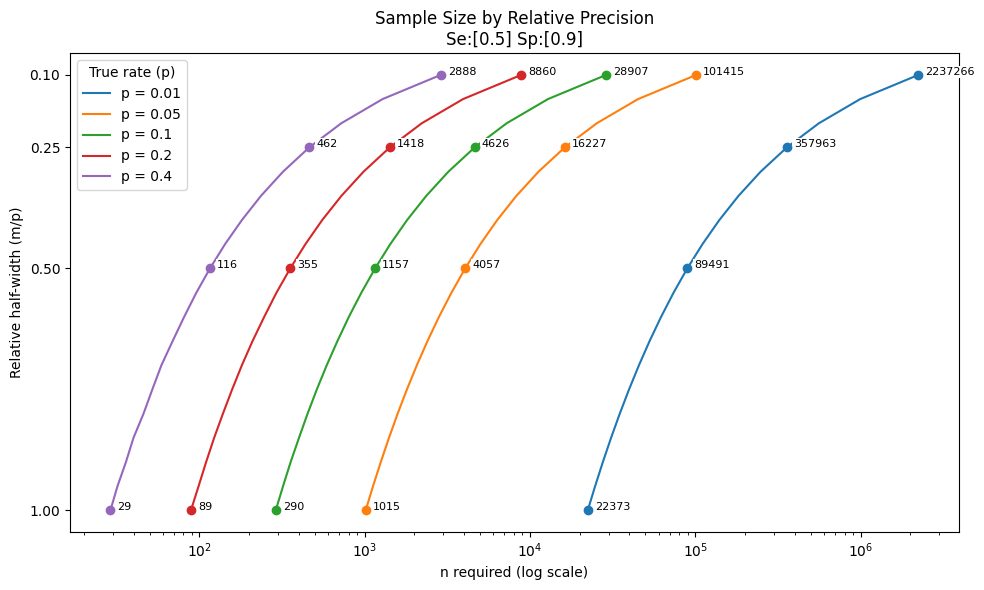

In [9]:
# Fine-grained data for smooth lines
m_fracs_fine = np.arange(0.1, 1.05, 0.05)  # m as fraction of p (10% to 100%)
ps = [0.01, 0.05, 0.10, 0.20, 0.4]
ses = [0.5]
sps = [.9]

rows_fine = []
for p in ps:
    for m_frac in m_fracs_fine:
        m = m_frac * p
        for se in ses:
            for sp in sps:
                n = n_required(p, se, sp, m=m)
                rows_fine.append({'p': p, 'm_frac': m_frac, 'm': m, 'n_required': n})

df_fine = pd.DataFrame(rows_fine)

# Sparse data for points and labels
m_fracs_points = [0.1, 0.25, 0.5, 1.0]
rows_points = []
for p in ps:
    for m_frac in m_fracs_points:
        m = m_frac * p
        for se in ses:
            for sp in sps:
                n = n_required(p, se, sp, m=m)
                rows_points.append({'p': p, 'm_frac': m_frac, 'm': m, 'n_required': n})

df_points = pd.DataFrame(rows_points)

# Plot - using m_frac on y-axis for comparability across p values
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10.colors

for i, (p, group) in enumerate(df_fine.groupby('p')):
    ax.plot(group['n_required'], group['m_frac'], color=colors[i], label=f'p = {p}')
    
    points = df_points[df_points['p'] == p]
    ax.scatter(points['n_required'], points['m_frac'], color=colors[i], zorder=5)
    
    for _, row in points.iterrows():
        ax.annotate(f'{int(row["n_required"])}', 
                    (row['n_required'], row['m_frac']),
                    textcoords='offset points',
                    xytext=(5, 0),
                    fontsize=8,
                    bbox=dict(facecolor='white', edgecolor='none', pad=1))

ax.set_xscale('log')
ax.invert_yaxis()
ax.set_yticks([0.1, 0.25, 0.5, 1.0])
ax.set_xlabel('n required (log scale)')
ax.set_ylabel('Relative half-width (m/p)')
ax.legend(title='True rate (p)')
ax.set_title(f'Sample Size by Relative Precision\nSe:{ses} Sp:{sps}')
plt.tight_layout()
plt.show()
